In [6]:
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import mean_squared_error
import scipy.stats
import seaborn as sns
from matplotlib import cm, pyplot as plt
from scipy import stats as st
from sklearn.utils import resample

sns.set()


In [38]:
def load_data(asset, level):
    data = pd.read_csv('./order_books_data_archive/AAPL_2012-06-21_34200000_57600000_orderbook_1.csv'.format(asset, level), header=None)
    
    levels = list(range(1, level + 1))
    iters = [iter(levels), iter(levels), iter(levels), iter(levels)]
    abv = ['ask', 'volume_ask', 'bid', 'volume_bid'] * level
    nums = [x for x in itertools.chain.from_iterable(itertools.zip_longest(levels, levels, levels, levels)) if x]
    data.columns = list(map(lambda x, y: '{0}_{1}'.format(x, y), abv, nums))
    
    return data

In [32]:


def feature_engineering(ds, level, num_lags):
    out_ds = pd.DataFrame()
    
    for i in range(1, level + 1):
        out_ds['log_return_ask_{0}'.format(i)] = np.log(ds['ask_{0}'.format(i)].pct_change() + 1)
        out_ds['log_return_bid_{0}'.format(i)] = np.log(ds['bid_{0}'.format(i)].pct_change() + 1)
        
        out_ds['log_ask_{0}_div_bid_{0}'.format(i)] = np.log(ds['ask_{0}'.format(i)] / ds['bid_{0}'.format(i)])
        out_ds['log_volume_ask_{0}_div_bid_{0}'.format(i)] = np.log(ds['volume_ask_{0}'.format(i)] / ds['volume_bid_{0}'.format(i)])
        
        out_ds['log_volume_ask_{0}'.format(i)] = np.log(ds['volume_ask_{0}'.format(i)])
        out_ds['log_volume_bid_{0}'.format(i)] = np.log(ds['volume_bid_{0}'.format(i)])
        
        if i != 1:
            out_ds['log_ask_{0}_div_ask_1'.format(i)] = np.log(ds['ask_{0}'.format(i)] / ds['ask_1'])
            out_ds['log_bid_{0}_div_bid_1'.format(i)] = np.log(ds['bid_{0}'.format(i)] / ds['bid_1'])
            out_ds['log_volume_ask_{0}_div_ask_1'.format(i)] = np.log(ds['volume_ask_{0}'.format(i)] / ds['volume_ask_1'])
            out_ds['log_volume_bid_{0}_div_bid_1'.format(i)] = np.log(ds['volume_bid_{0}'.format(i)] / ds['volume_bid_1'])
        
    out_ds['log_total_volume_ask'] = np.log(ds[['volume_ask_{0}'.format(x) for x in list(range(1, level + 1))]].sum(axis = 1))
    out_ds['log_total_volume_bid'] = np.log(ds[['volume_bid_{0}'.format(x) for x in list(range(1, level + 1))]].sum(axis = 1))
            
    mid_price = (ds['ask_1'] + ds['bid_1']) / 2
    out_ds['log_return_mid_price'] = np.log(mid_price.pct_change() + 1).shift(-1)
        
    cols_features = out_ds.columns.drop(target_column)
    out_ds = out_ds.assign(**{
        '{}_(t-{})'.format(col, t): out_ds[col].shift(t)
        for t in list(range(1, num_lags))
        for col in cols_features})
    
    return out_ds.dropna()

In [33]:
target_column = 'log_return_mid_price'

In [34]:
source_data = load_data('AAPL', 1)
dataset = feature_engineering(source_data, 1, 1)


/Users/lisetlopez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lisetlopez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lisetlopez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


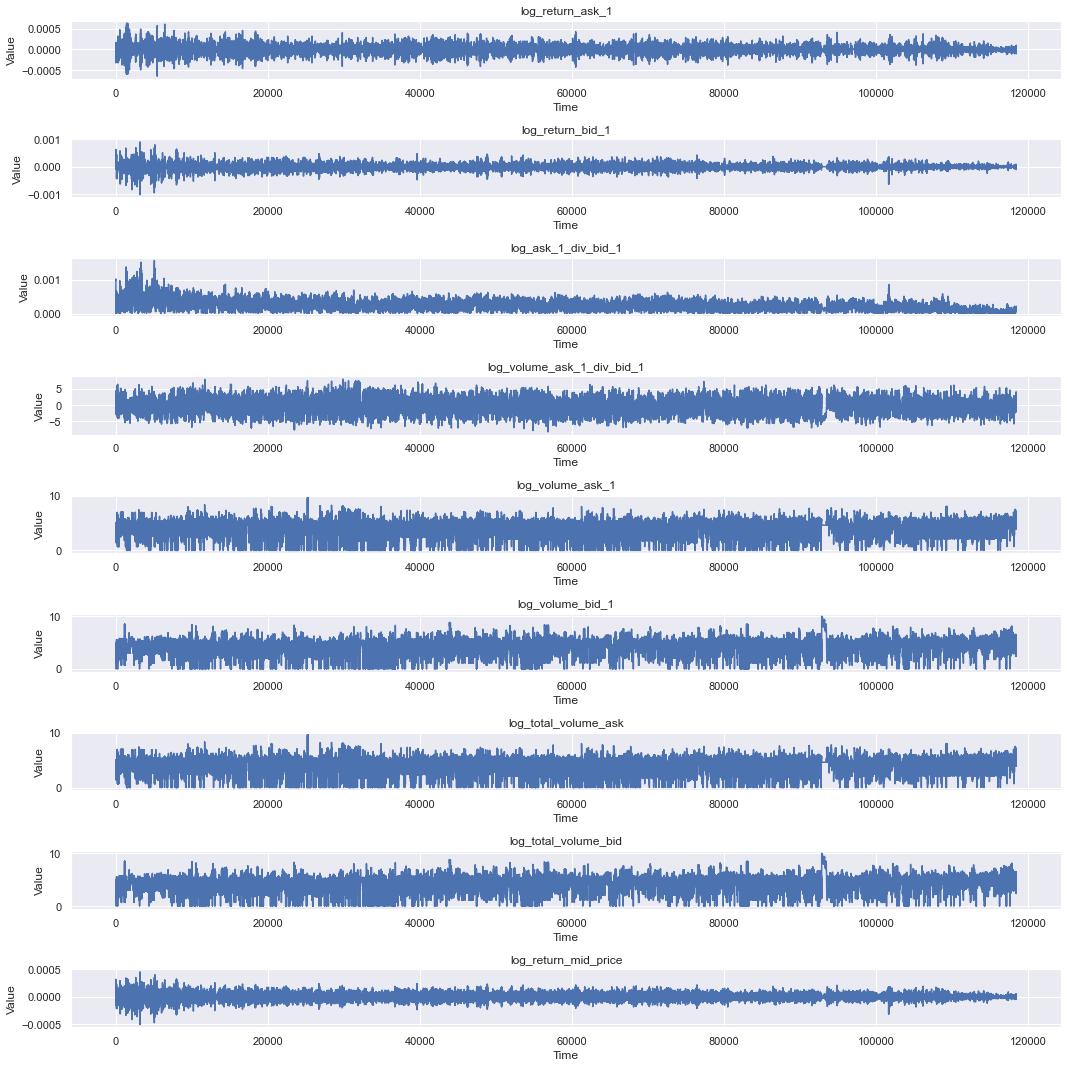

In [35]:
fig, axs = plt.subplots(len(dataset.columns), 1, figsize = (15, 15))
for i in range(0, len(dataset.columns)):
    c = dataset.columns[i]
    
    axs[i].plot(dataset[c])
    axs[i].set_title(c)
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Value')
plt.tight_layout()
plt.show()




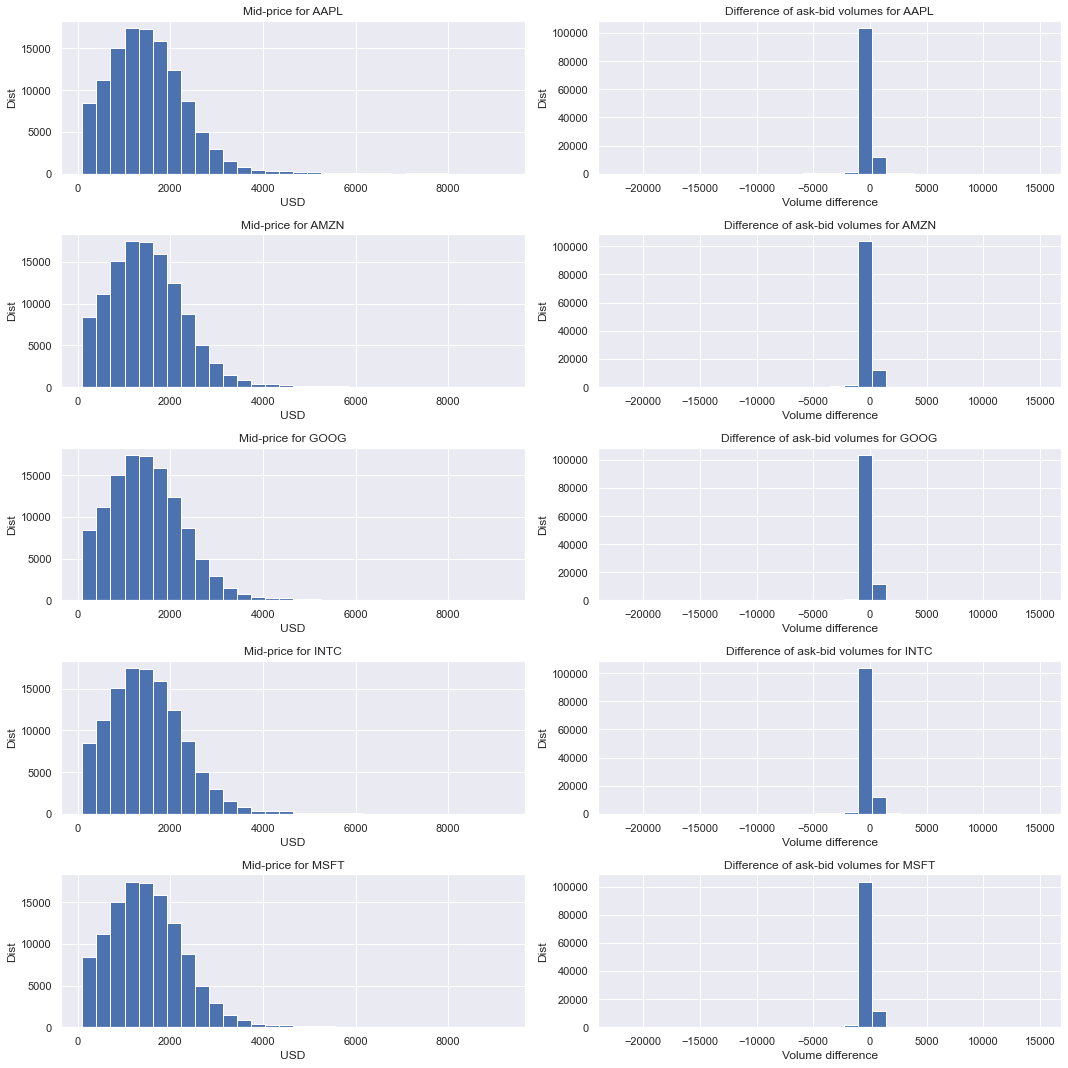

In [30]:
assets = ['AAPL', 'AMZN', 'GOOG', 'INTC', 'MSFT']
fig, axs = plt.subplots(len(assets), 2, figsize = (15, 15))
colours = cm.prism(np.linspace(0, 1, len(assets)))

for i, (ax, colour) in enumerate(zip(axs, colours)):
    asset = assets[i]
    source_data = load_data(asset, 1)
    diff_volumes = source_data.volume_ask_1 - source_data.volume_bid_1
    mid_price = source_data.ask_1 - source_data.bid_1
    
    ax[0].hist(mid_price[~np.isnan(mid_price)], bins = 30)
    ax[0].set_title('Mid-price for ' + asset)
    ax[0].set_xlabel('USD')
    ax[0].set_ylabel('Dist')
    
    ax[1].hist(diff_volumes[~np.isnan(diff_volumes)], bins = 30)
    ax[1].set_title('Difference of ask-bid volumes for ' + asset)
    ax[1].set_xlabel('Volume difference')
    ax[1].set_ylabel('Dist')
    
plt.tight_layout()
